#**Advanced Machine Learning Applications for Market Analysis**


####ELE 391: Machine Learning for Engineering Applications I
####Richard Buckley, Daniel Sanguino, Garrett Kemper
####December 5, 2024

This work was done for ELE-391 at the Univeristy of Rhode Island, taught by Dr. Chiovaro.

GitHub: https://github.com/gkemp181/Market-Analysis-Project

#**1. Problem Definition:**

We aim to use machine learning models to examine and identify patterns, trends, and correlations within the financial markets, to provide insights into market behavior. By leveraging time-series data, economic indicators and other financial variables, we seek to detect market movements and assess the degree of predictability within the market.

To solve this problem, two different models will be trained and their results will be compared to evaulate their ability to make these predictions. The models that will be used are a Hidden Markov Model (HMM) and a Long Short-Term Memory (LSTM) Model.

#**2. Data Acquisition and Analysis:**



*   Import necessary libraries and packages.
*   Load the dataset into a DataFrame
*   Explanation of raw data.



In [ ]:
from IPython.display import clear_output
clear_output()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

try:
  import mplfinance as mpf
  from hmmlearn.hmm import GaussianHMM
except:
  %pip install hmmlearn mplfinance
  import mplfinance as mpf
  from hmmlearn.hmm import GaussianHMM

clear_output()

###Importing the file from google drive

**Note:** If using the shared folder, you must add a shortcut to the shared folder to your drive.

Right Click on Folder > Organize > Add Shortcut to drive.

In [ ]:
def read_csv_from_drive(file_name, drive_fp='My Drive/ELE391 Final Project'):
  from google.colab import drive
  drive.mount('/content/drive')

  file_path = f'/content/drive/{drive_fp}/{file_name}'

  try:
      df = pd.read_csv(file_path, index_col=0)
      df["Date"] = pd.to_datetime(df["Date"])
      return df
      print("Successfully imported CSV file into DataFrame.")
  except FileNotFoundError:
      print(f"Error: File not found at {file_path}. Please check the file path.")
      print("Please ensure that you added a shortcut to the shared folder to your drive")
      print("Right Click on Folder > Organize > Add Shortcut to drive.")
  except pd.errors.EmptyDataError:
      print(f"Error: The CSV file at {file_path} is empty.")
      print("Please ensure that you added a shortcut to the shared folder to your drive")
      print("Right Click on Folder > Organize > Add Shortcut to drive.")
  except pd.errors.ParserError:
      print(f"Error: Could not parse the CSV file at {file_path}. Please check the file format.")
      print("Please ensure that you added a shortcut to the shared folder to your drive")
      print("Right Click on Folder > Organize > Add Shortcut to drive.")
  except Exception as e:
      print(f"An unexpected error occurred: {e}")
      print("Please ensure that you added a shortcut to the shared folder to your drive")
      print("Right Click on Folder > Organize > Add Shortcut to drive.")

### Variables

Here are the variables that our project will be utilizing. Because this single dataset only touches on this field, we want to make the dataset as easy to change as possible.

In [ ]:
# Load dataframe from CSV file
df = read_csv_from_drive('dataset_v2.csv')

# The stock ticker that will be used for our models
TICKER = "AAPL"

TRAIN_SIZE = 0.7  # the percentage of samples used for training
TEST_SIZE  = 0.2  # ... testing
VAL_SIZE   = 0.1  # ... validation

# Here are the bins that will be used for predicting the movement of the stock i.e. the target to classify the stock into.
_pct_change = df["Close"].pct_change()
_points_between = np.linspace(-0.2, 0.2, 10)
CLASSIFICATION_BINS = _points_between

# How far in the future do we want to predict
PREDICTION_WINDOW = 5  # 1 weeks

# Exclude the IncomeStatement Columns for now
df = df[[col for col in df.columns if not col.startswith('IncomeStatement')]]

Mounted at /content/drive


###Information and Statistics of Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 720 entries, 0 to 719
Data columns (total 49 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date                              720 non-null    datetime64[ns]
 1   Adj Close                         720 non-null    float64       
 2   Close                             720 non-null    float64       
 3   High                              720 non-null    float64       
 4   Low                               720 non-null    float64       
 5   Open                              720 non-null    float64       
 6   Volume                            720 non-null    int64         
 7   52_Week_High                      720 non-null    float64       
 8   52_Week_Low                       720 non-null    float64       
 9   SMA50                             720 non-null    float64       
 10  SMA200                            720 non-null    float

In [ ]:
df.describe()

Date   Adj Close       Close        High         Low  \
count                  720  720.000000  720.000000  720.000000  720.000000   
mean   2023-06-06 05:58:00  175.175070  175.175070  176.888389  173.301806   
min    2021-12-30 00:00:00  125.019997  125.019997  127.769997  124.169998   
25%    2022-09-18 06:00:00  154.932499  154.932499  156.740005  153.042500   
50%    2023-06-06 12:00:00  172.834999  172.834999  174.044998  171.019997   
75%    2024-02-23 18:00:00  189.692501  189.692501  190.654995  188.327499   
max    2024-11-08 00:00:00  236.479996  236.479996  237.490005  234.449997   
std                    NaN   26.037529   26.037529   25.984056   26.046419   

             Open        Volume  52_Week_High  52_Week_Low       SMA50  ...  \
count  720.000000  7.200000e+02    720.000000   720.000000  720.000000  ...   
mean   175.024945  6.915760e+07    191.873430   191.873430  171.694671  ...   
min    126.010002  2.404830e+07    172.447495   172.447495  137.316588  ...   
25%    154.754993  5.001420e+07    179.076584   179.076584  154.030460  ...   
50%    172.494995  6.395575e+07    179.588394   179.588394  169.641730  ...   
75%    189.524998  8.143422e+07    197.144180   197.144180  184.491821  ...   
max    236.479996  3.186799e+08    236.220108   236.220108  226.926336  ...   
std     26.060287  2.821082e+07     18.610630    18.610630   23.194743  ...   

       Correlated_ADX  Correlated_NIE  Correlated_EOS  Correlated_QQQX  \
count      720.000000      720.000000      720.000000       720.000000   
mean        16.216195       21.888264       16.706975        21.630322   
min         12.354394       18.170000       12.673201        17.689409   
25%         14.010049       20.420000       14.494265        20.304204   
50%         15.277506       21.549999       16.029639        21.479883   
75%         18.444519       22.802499       18.739976        22.875634   
max         22.530001       29.549999       23.030001        26.299999   
std          2.846111        1.984955        2.602282         1.898005   

       Correlated_BST  Correlated_CSQ  Correlated_MSFT  Correlated_ETG  \
count      720.000000      720.000000       720.000000      720.000000   
mean        34.850007       15.137014       331.013222       15.479206   
min         28.070000       12.200000       214.250000       12.332503   
25%         32.180000       13.990000       268.654991       14.060437   
50%         34.330002       14.865000       321.829987       15.093068   
75%         36.599998       16.332500       406.327507       16.846546   
max         49.131287       18.802198       467.559998       19.337528   
std          3.574197        1.446695        68.989451        1.789712   

       Correlated_ETY  Correlated_EXG  
count      720.000000      720.000000  
mean        11.204052        8.132456  
min          8.938943        6.790000  
25%         10.104769        7.740000  
50%         10.787205        7.960000  
75%         12.244742        8.440000  
max         14.980139       10.532752  
std          1.506581        0.614946  

[8 rows x 49 columns]

In [ ]:
df.head()

Date   Adj Close       Close        High         Low        Open  \
0 2021-12-30  178.199997  178.199997  180.570007  178.089996  179.470001   
1 2021-12-31  177.570007  177.570007  179.229996  177.259995  178.089996   
2 2022-01-03  182.009995  182.009995  182.880005  177.710007  177.830002   
3 2022-01-04  179.699997  179.699997  182.940002  179.119995  182.630005   
4 2022-01-05  174.919998  174.919998  180.169998  174.639999  179.610001   

      Volume  52_Week_High  52_Week_Low       SMA50  ...  Correlated_ADX  \
0   59773000    177.423706   177.423706  158.876484  ...       16.269091   
1   64062300    177.423706   177.423706  159.437839  ...       16.041491   
2  104487900    179.076584   179.076584  160.082240  ...       16.117357   
3   99310400    179.076584   179.076584  160.696709  ...       15.771742   
4   94537600    179.076584   179.076584  161.218101  ...       15.611580   

   Correlated_NIE  Correlated_EOS  Correlated_QQQX  Correlated_BST  \
0       29.549999       18.268600        23.806171       49.131287   
1       29.410000       18.072416        23.489511       47.450821   
2       28.740000       18.025335        23.286530       47.391159   
3       28.010000       17.491713        22.628855       45.352722   
4       27.799999       17.444633        22.222883       44.815769   

   Correlated_CSQ  Correlated_MSFT  Correlated_ETG  Correlated_ETY  \
0       18.802198       318.269989       18.040215       11.676160   
1       18.573509       304.799988       17.810352       11.535393   
2       18.553623       310.200012       17.754875       11.488467   
3       18.136017       302.649994       17.493299       11.332055   
4       17.966988       303.329987       17.517090       11.230388   

   Correlated_EXG  
0       10.532752  
1       10.493303  
2       10.503164  
3       10.335507  
4       10.325646  

[5 rows x 49 columns]

In [ ]:
mpf.plot(df.set_index('Date'), type='line', volume=True, style='binance', figsize=(14,9), title=f"Price of {TICKER}")

This dataset is made up of stock values of AAPL over a period of about three years. It contains 49 features. The most important of which include 'Date', 'Close', 'High', and 'Volume'. There are 720 instances in this dataset, each one representing one business day of this stock.

*   'Date' represents the date of that instance.
*   'Close' represents the value of the stock at the close of the market that day.
*   'High' is the highest value of the stock on that day.
*   'Volume' is the number of shares of the stock that were traded on that day.

This dataset contains data from December 30, 2021 to November 8th, 2024.

An important part of this dataset is the date. Since the goal of this model is to make predictions based on historical data, it is important that it is being given time-series data. It is also important to note that maintaining the chronology of this data is going to be important for the model to be accurate.

#**3. Data Cleaning and Preparation:**



### Processing the Data

- Ensure that there are no NaN values by dropping them.
- Replace column Close with Adj. Close.
  - Adjusted Close takes into account movements, such as stock splits, which makes it more accurate and easier to work with.
- Data scaling only required for LSTM, not HMM so it will not be done in this section.
  - For LSTM, data will need to be Min-Max scaled from 0 to 1.
- Outlier Detection - We will not do this, as intermediary data is import (and usually very accurate).
- Create target column

In [ ]:
# Drop NaN values as they are not useful to this model
df = df.dropna()
df = df.reset_index(drop=True)

In [ ]:
# Replace the 'Close' column with 'Adj Close' and remove 'Adj Close'
df["Close"] = df["Adj Close"]
df = df.drop(columns=["Adj Close"])

In [ ]:
# skipping outlier detection
# all data is important and reliable

In [ ]:
# Create Target Variable
df["Target"] = df["Close"].shift(-PREDICTION_WINDOW)
df["Target"] = df["Target"].pct_change()

# add hidden binary up/down to model
df["_FutureIncreased"] = np.where(df["Target"] > df["Close"], 1, 0)

df = df.dropna()  # we cannot make a prediction for all days
df = df.reset_index(drop=True)

# one hot encoded values
one_hot_encoded = pd.get_dummies(
    pd.cut(df["Target"], bins=CLASSIFICATION_BINS),
    prefix="Target"
)

# add to dataframe ; drop target numeric prediction
df = pd.concat([df, one_hot_encoded], axis=1)
df = df.iloc[:-PREDICTION_WINDOW]
clear_output()

In [ ]:
# make date "hidden"
df = df.rename(columns={"Date": "_Date", "Target": "_Target"})

### Feature Engineering:

Much of the feature engineering is present in another script where we introduce the following indicators (by engineering features in original High, Low, Close, Volume)... See below. Script available in github repository.

```
7   52_Week_High                      720 non-null    float64
8   52_Week_Low                       720 non-null    float64
9   SMA50                             720 non-null    float64
10  SMA200                            720 non-null    float64
11  EMA50                             720 non-null    float64
12  EMA200                            720 non-null    float64
13  MACD                              720 non-null    float64
14  MACD_S                            720 non-null    float64
15  MACD_H                            720 non-null    float64
16  ADX                               720 non-null    float64
17  RSI50                             720 non-null    float64
18  RSI200                            720 non-null    float64
19  %K                                720 non-null    float64
20  %D                                720 non-null    float64
21  %Change                           720 non-null    float64
22  OBV                               720 non-null    float64
23  CMF                               720 non-null    float64
24  VWAP                              720 non-null    float64
25  Bollinger_UP                      720 non-null    float64
26  Bollinger_DOWN                    720 non-null    float64
27  Bollinger_WIDTH                   720 non-null    float64
28  ATR                               720 non-null    float64
29  Volatility                        720 non-null    float64
 ```

 We are still, however, interested in the interactions between many of these features. For that reason we will be looking to add more features in the future to improve our model.

### Splitting our Data

In our presentation, we briefly touched on the dangers of `train_test_split` for our use case, so what is the alternative?

We can simply index our data. It is also important to note that the LSTM and HMM models that we will be showing below require different types of engineering.

If we provide all of the columns to the LSTM, we can add countermeasures to reduce bias, and further investigate the significance of each column.

For the HMM, providing even half as many features as we have, will bias the model. We will be defining a separate set of variables for the HMM.

In [ ]:
# these are "hidden" columns that we use for evaluation
avail_cols = [col for col in df.columns if not col.startswith("_")]

# create list of x and y column names
y_cols = [col for col in avail_cols if col.startswith("Target")]
X_cols = [col for col in avail_cols if col not in y_cols]

# Use Google Colab to browse the df
pd.DataFrame({
    "X_cols (Feature Columns)": pd.Series(X_cols),
    "y_cols (Target Columns)": pd.Series(y_cols),
}).head()

X_cols (Feature Columns)    y_cols (Target Columns)
0                    Close      Target_(-0.2, -0.156]
1                     High    Target_(-0.156, -0.111]
2                      Low   Target_(-0.111, -0.0667]
3                     Open  Target_(-0.0667, -0.0222]
4                   Volume   Target_(-0.0222, 0.0222]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

_df = df.copy()
cols_to_scale = [col for col in df.columns if df[col].dtype != 'object'and col not in ["_Date", "_Target"]]

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

The columns created below will be the predictors used by the HMM to train and test it. These changes allow the model to predict percent changes rather than the exact values, which will help in accuracy and in our binning output.

**HMM Columns**

- $\Delta$ Open, Close
- $\Delta$ Open, High
- $\Delta$ Open, Low

In [ ]:
df_hmm = _df.copy()  # we need unscaled data.

df_hmm["pct_change_open"] = (df_hmm["Close"] - df_hmm["Open"]) / df_hmm["Open"]
df_hmm["pct_change_low_open"] = (df_hmm["Low"] - df_hmm["Open"]) / df_hmm["Open"]
df_hmm["pct_change_high_open"] = (df_hmm["High"] - df_hmm["Open"]) / df_hmm["Open"]

X_cols_hmm = ["pct_change_open", "pct_change_low_open", "pct_change_high_open",
              "Volatility", "Bollinger_UP", "%K"]

##**Feature Selection**

The following sections evaluate the correlation of different features with our targets. This will help in feature selection and in determining the best features to use to make accurate predictions.

The two methods of feature selection will be SelectKBest and Mutual Scores.

SelectKBest selects the top k features from the dataset based on a given test. In this case, it is using f_regression.

Mutual Scores measures the dependency between two variables to determine correlation.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

# Using SelectKBest to pick the best 10 features
selector = SelectKBest(f_regression)
selector.fit_transform(df[X_cols], df['_Target'])
df[X_cols].columns[selector.get_support()]

Index(['RSI200', 'CMF', 'Correlated_ADX', 'Correlated_EOS', 'Correlated_QQQX',
       'Correlated_BST', 'Correlated_CSQ', 'Correlated_MSFT', 'Correlated_ETG',
       'Correlated_ETY'],
      dtype='object')

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Plotting the correlation of features with targets using SelectKBest. Darker colors are more correlated
selector_info = pd.DataFrame()
selector = SelectKBest(f_classif)
for label in y_cols:
  selector.fit_transform(df[X_cols], df[label])
  selector_info[label] = pd.Series(selector.scores_, index=df[X_cols].columns)
clear_output()
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(selector_info.div(selector_info.sum()).T, ax=ax, cmap='Blues');

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Plotting the correlation of features with targets using mutual scores. Darker colors are more correlated
mutual_info = pd.DataFrame()
for label in y_cols:
  mi = mutual_info_classif(
      X=df[X_cols],
      y=(df[label] > 0).astype(int)
  )

  mutual_info[label] = pd.Series(mi, index=df[X_cols].columns)

In [ ]:
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(mutual_info.div(mutual_info.sum()).T, ax=ax, cmap='Blues');

#**4. Model Training:**

###Model 1 - HMM:

A Hidden Markov Model (HMM) is a statistical model used to describe systems that are governed by unobservable (hidden) states. It is widely applied in areas like natural language processing, speech recognition, and time-series analysis.

What is a Hidden Markov Model? The Hidden Markov Model is based on states, and the probabilities of transitioning between states. For instance, given input variables, the Hidden Markov Model may compute the probability of transitioning to the next state - see more below.

For this case, we are using it for time-series analysis.


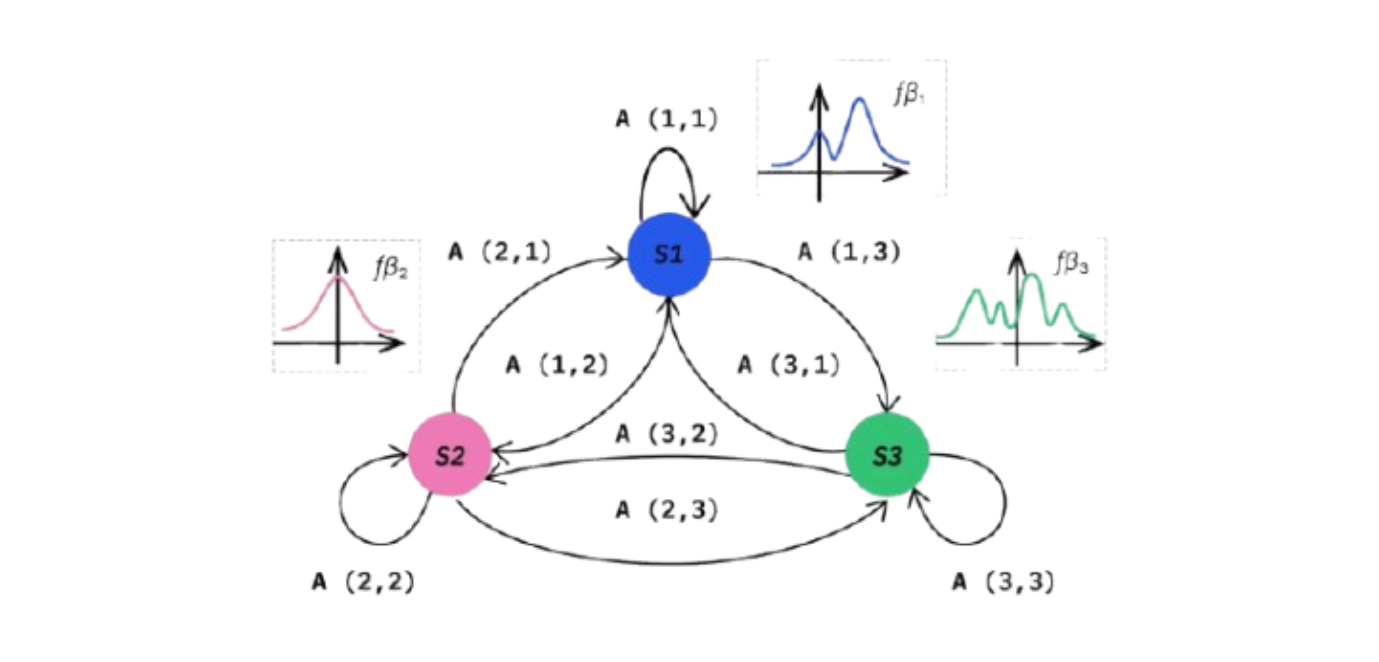

In [ ]:
from sklearn.preprocessing import StandardScaler

# Regimes are the "Clusters" that the data will be grouped into
regimes = {
    "Regime 1": "orange",
    "Regime 2": "red",
    "Regime 3": "green",
    "Regime 4": "gray",

}

# Training and fitting the model
data = StandardScaler().fit_transform(df_hmm[X_cols_hmm])
model = GaussianHMM(n_components=len(regimes.keys()), covariance_type="full", random_state=42)
model.fit(data[:int(len(data)*(TRAIN_SIZE+VAL_SIZE))])

df_hmm['Hidden_State'] = model.predict(data)

sns.set_style("darkgrid")
sns.set_palette("colorblind")


# Ensure 'Hidden_State' is a categorical variable for better color handling
df_hmm['Hidden_State'] = df_hmm['Hidden_State'].astype('category')
clear_output()

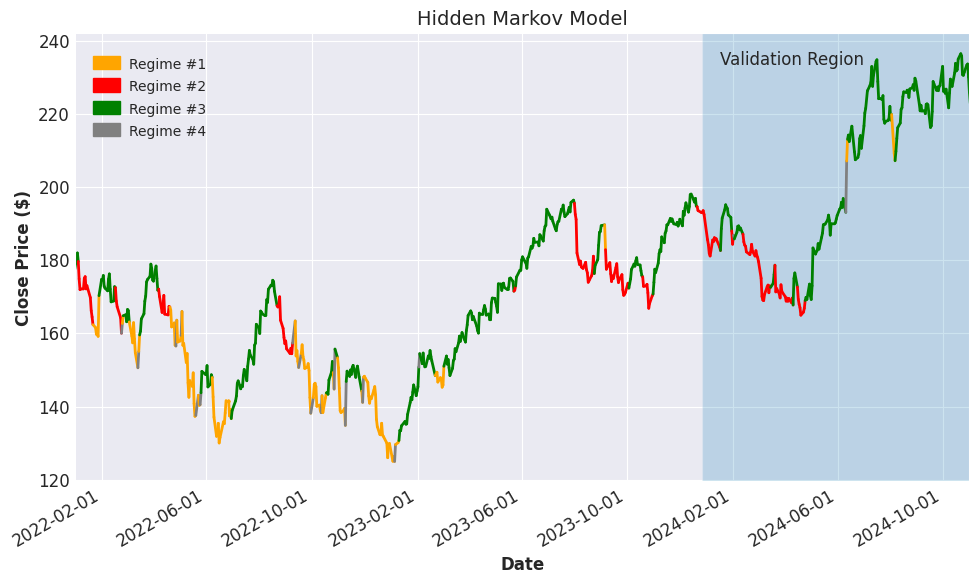

In [ ]:
# this block plots the regimes
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

# Set Seaborn style
sns.set_style("darkgrid")

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size for clarity

# Format the x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate date labels

# Plot the line with hue for hidden states
index = pd.to_datetime(_df['_Date'])
last = index.iloc[0], df_hmm['Close'].iloc[0], df_hmm['Hidden_State'].iloc[0]
for x, y, state in zip(index, df_hmm['Close'], df_hmm['Hidden_State']):
    lx, ly, ls = last
    plt.plot([lx, x], [ly, y], color=list(regimes.values())[state], linewidth=2)
    last = x, y, state

# Set x-axis limits explicitly
ax.set_xlim(index.min(), index.max())

# Add title and labels
plt.title("Hidden Markov Model", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price ($)", fontsize=12)

# Add a label for each regime
for i, [key, color] in enumerate(regimes.items()):
  square = mpatches.Rectangle((0.02, 0.92 - 0.05 * i), 0.03, 0.03, color=color, transform=ax.transAxes)
  ax.add_patch(square)
  ax.text(0.06, 0.93 - 0.05 * i, f"Regime #{i+1}", transform=ax.transAxes, fontsize=10, verticalalignment="center")

# Line showing where training ended
train_start_idx = int(len(data) * TRAIN_SIZE)

ax.axvspan(index.iloc[train_start_idx], index.iloc[-1], alpha=0.2)
ax.text(0.72, 0.93, "Validation Region", transform=ax.transAxes)

# Final adjustments
plt.tight_layout()
plt.show()

## Model Results

What does this model tell us / how is it helpful?

The Hidden Markov Model is widely used for time-series analysis, and helps capture the different states, by creating three matrices: a mean matrix (the normal mean of the outcome for each state), a transition matrix (the probability of transitioning from one state to another), and then a starting probabilities matrix.




Why is this data relevant? Well, as we know, it is very hard to predict the stock market, and there are a lot of factors in play, that data, simply cannot model. Instead of collecting an endless amount of data, we can train an **Hidden Markov Model** which determines "regimes" of data, determines the probability for each "regime" to transition to another, and then we can use EDA to analyze the results.


Another common application of the HMM is to use the regimes outputted in order to train separate LSTM (or some other) model, for each regime.


One helpful way to think of the "regimes" or the "clusters" that this model produces is as operating conditions for the data that a given model uses to be valid.

###Model 2 - LSTM:


The goal of an LSTM is to analyze data that has long-term dependencies. An LSTM is a type of Recurrent Neural Network (RNN). It expands off of an RNN with the ability to store long term memory and enables the model to make long term predictions. LSTMs are most often used for language translation, speech recognition, and time series forecasting. Its use in time series forecasting is the most important for this project. In this application, an LSTM can use historic data to identify patterns and trends which can be used to predict future stock prices.

In [ ]:
# Create new X_cols variable
X_cols_ = X_cols

In [ ]:
# Adjust variables to new dataset
X_cols = [c for c in X_cols if c not in ['Close', 'Open']]
df["pct_change_open"] = (_df["Close"] - _df["Open"]) / _df["Open"]
df["pct_change_low_open"] = (_df["Low"] - _df["Open"]) / _df["Open"]
df["pct_change_high_open"] = (_df["High"] - _df["Open"]) / _df["Open"]
X_cols.extend(["pct_change_open", "pct_change_low_open", "pct_change_high_open"])
X_cols = list(set(X_cols))

## Attempt 1: Predict Target (Shifted %Change)

This model is attempting to find the percent change of the stock over a window of time.

In [ ]:
# Split our X data into train, test & validation dataframes
X_train = df[X_cols].iloc[:int(TRAIN_SIZE * len(df))]
X_test  = df[X_cols].iloc[int(TRAIN_SIZE * len(df)):int((TRAIN_SIZE + TEST_SIZE) * len(df))]
X_val   = df[X_cols].iloc[int((TRAIN_SIZE + TEST_SIZE) * len(df)):]

# Split our y data into train, test & validation dataframes
y_train = df['_Target'].iloc[:int(TRAIN_SIZE * len(df))]
y_val   = df['_Target'].iloc[int(TRAIN_SIZE * len(df)):int((TRAIN_SIZE + TEST_SIZE) * len(df))]
y_test  = df['_Target'].iloc[int((TRAIN_SIZE + TEST_SIZE) * len(df)):]

# reformat the data for the lstm
def plstm(data, timestep=1):
    """
    Reformats the data to ensure each sample contains `timestep` previous samples.
    :param data: DataFrame or ndarray, input data
    :param timestep: int, number of previous time steps to include
    :return: ndarray of shape (n_samples - timestep + 1, timestep, n_features)
    """
    data = data.values  # Convert to numpy array if DataFrame
    n_samples, n_features = data.shape

    # Ensure enough samples for timesteps
    assert n_samples >= timestep, "Number of samples must be greater than or equal to timestep"

    # Create sliding windows
    windows = np.array([data[i:i + timestep] for i in range(n_samples - timestep + 1)])
    return windows

# Parameters
TIMESTEP = 14

# Reform data for LSTM
LX_train = plstm(X_train, TIMESTEP)
LX_val = plstm(X_val, TIMESTEP)
LX_test = plstm(X_test, TIMESTEP)

# reshape and cut :14
y_train = y_train[TIMESTEP-1:].values.reshape(-1, 1)
y_val   = y_val[TIMESTEP-1:].values.reshape(-1, 1)
y_test  = y_test[TIMESTEP-1:].values.reshape(-1, 1)

In [ ]:
# Split our X data into train, test & validation dataframes
X_train = df[X_cols].iloc[:int(TRAIN_SIZE * len(df))]
X_val   = df[X_cols].iloc[int(TRAIN_SIZE * len(df)):int((TRAIN_SIZE + TEST_SIZE) * len(df))]
X_test  = df[X_cols].iloc[int((TRAIN_SIZE + TEST_SIZE) * len(df)):]

# Split our y data into train, test & validation dataframes

y_train = df['_Target'].iloc[:int(TRAIN_SIZE * len(df))]
y_val   = df['_Target'].iloc[int(TRAIN_SIZE * len(df)):int((TRAIN_SIZE + TEST_SIZE) * len(df))]
y_test  = df['_Target'].iloc[int((TRAIN_SIZE + TEST_SIZE) * len(df)):]

# reformat the data for the lstm
def plstm(data, timestep=1):
    """
    Reformats the data to ensure each sample contains `timestep` previous samples.
    :param data: DataFrame or ndarray, input data
    :param timestep: int, number of previous time steps to include
    :return: ndarray of shape (n_samples - timestep + 1, timestep, n_features)
    """
    data = data.values  # Convert to numpy array if DataFrame
    n_samples, n_features = data.shape

    # Ensure enough samples for timesteps
    assert n_samples >= timestep, "Number of samples must be greater than or equal to timestep"

    # Create sliding windows
    windows = np.array([data[i:i + timestep] for i in range(n_samples - timestep + 1)])
    return windows

# Parameters
TIMESTEP = 30

# Reform data for LSTM
LX_train = plstm(X_train, TIMESTEP)
LX_val = plstm(X_val, TIMESTEP)
LX_test = plstm(X_test, TIMESTEP)

# reshape and cut :14
y_train = y_train[TIMESTEP-1:].values.reshape(-1, 1)
y_val   = y_val[TIMESTEP-1:].values.reshape(-1, 1)
y_test  = y_test[TIMESTEP-1:].values.reshape(-1, 1)

from tqdm.keras import TqdmCallback
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# y_min_max_scaler = MinMaxScaler()
# y_min_max_scaler.fit(np.row_stack((y_train, y_val, y_test)))

# sy_train = y_min_max_scaler.transform(y_train)
# sy_val = y_min_max_scaler.transform(y_val)
# sy_test = y_min_max_scaler.transform(y_test)

# Build the LSTM model
model = Sequential([
    Input(shape=(LX_train.shape[1], LX_train.shape[2])),  # (timesteps, features)
    LSTM(units=64, return_sequences=True),
    LSTM(units=32, return_sequences=False),
    Dense(units=32, activation='relu'),
    Dropout(0.2),
    Dense(units=16, activation='relu'),
    Dropout(0.2),
    Dense(units=1)
])

optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']), softmax

# We tried changing the loss function to huber loss, as it would
# help account for the fact, that direction matters, but it did
# not help us obtain "good enough"
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(
    LX_train,  # ensure we are providing the model with the lstm data (shape)
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(LX_val, y_val),
    callbacks=[
        TqdmCallback(verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ],
    verbose=0
)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


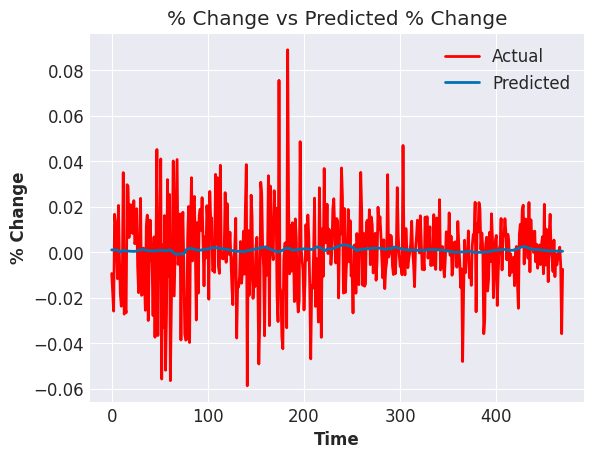

In [ ]:
# Plot predicted percent change vs actual percent change
plt.plot(y_train, color='red')
plt.plot(model.predict(LX_train))
plt.title("% Change vs Predicted % Change")
plt.xlabel("Time")
plt.ylabel("% Change")
plt.legend(["Actual", "Predicted"])
plt.show()

### Attempt #1: Results

Look at how noisy this graph is (we already knew this was going to be hard, but now, we must shift gears)

The graph above represents the % Change vs the Predicted % Change, and as we can see, the graph is so noisy that it is hard for the model to make a prediction.

Multiple layer combinations were attempted, however, we do not believe that this LSTM will yield good results unless the data is separated somehow. **Hint: HMM Regimes**, but that is a topic for another time.

## Attempt #2: Predict Target Bin (Shifted %Change, but binned)

This model will attempt to work similarly to the last one, however instead of finding the value, it will bin the results into different percentages.

In [ ]:
# Reset X_cols
X_cols = X_cols_

# Split our X data into train, test & validation dataframes
X_train = df[X_cols].iloc[:int(TRAIN_SIZE * len(df))]
X_val   = df[X_cols].iloc[int(TRAIN_SIZE * len(df)):int((TRAIN_SIZE + TEST_SIZE) * len(df))]
X_test  = df[X_cols].iloc[int((TRAIN_SIZE + TEST_SIZE) * len(df)):]

# Split our y data into train, test & validation dataframes

y_train = df[y_cols].iloc[:int(TRAIN_SIZE * len(df))]
y_val   = df[y_cols].iloc[int(TRAIN_SIZE * len(df)):int((TRAIN_SIZE + TEST_SIZE) * len(df))]
y_test  = df[y_cols].iloc[int((TRAIN_SIZE + TEST_SIZE) * len(df)):]

# reformat the data for the lstm
def plstm(data, timestep=1):
    """
    Reformats the data to ensure each sample contains `timestep` previous samples.
    :param data: DataFrame or ndarray, input data
    :param timestep: int, number of previous time steps to include
    :return: ndarray of shape (n_samples - timestep + 1, timestep, n_features)
    """
    data = data.values  # Convert to numpy array if DataFrame
    n_samples, n_features = data.shape

    # Ensure enough samples for timesteps
    assert n_samples >= timestep, "Number of samples must be greater than or equal to timestep"

    # Create sliding windows
    windows = np.array([data[i:i + timestep] for i in range(n_samples - timestep + 1)])
    return windows

# Parameters
TIMESTEP = 14

# Reform data for LSTM
LX_train = plstm(X_train, TIMESTEP)
LX_val = plstm(X_val, TIMESTEP)
LX_test = plstm(X_test, TIMESTEP)

# reshape and cut :14
y_train = y_train[TIMESTEP-1:].values.reshape(-1, len(y_cols))
y_val   = y_val[TIMESTEP-1:].values.reshape(-1, len(y_cols))
y_test  = y_test[TIMESTEP-1:].values.reshape(-1, len(y_cols))

In [ ]:
from tqdm.keras import TqdmCallback
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Build the LSTM model
model = Sequential([
    Input(shape=(LX_train.shape[1], LX_train.shape[2])),  # (timesteps, features)
    LSTM(units=64, return_sequences=True),
    LSTM(units=32, return_sequences=False),
    Dense(units=32, activation='relu'),
    Dropout(0.2),
    Dense(units=16, activation='relu'),
    Dropout(0.2),
    Dense(units=len(y_cols), activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# We tried changing the loss function to huber loss, as it would
# help account for the fact, that direction matters, but it did
# not help us obtain "good enough"
model.fit(
    LX_train,  # ensure we are providing the model with the lstm data (shape)
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(LX_val, y_val),
    callbacks=[
        TqdmCallback(verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ],
    verbose=0
)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
# Make predictions
y_pred = model.predict(LX_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step


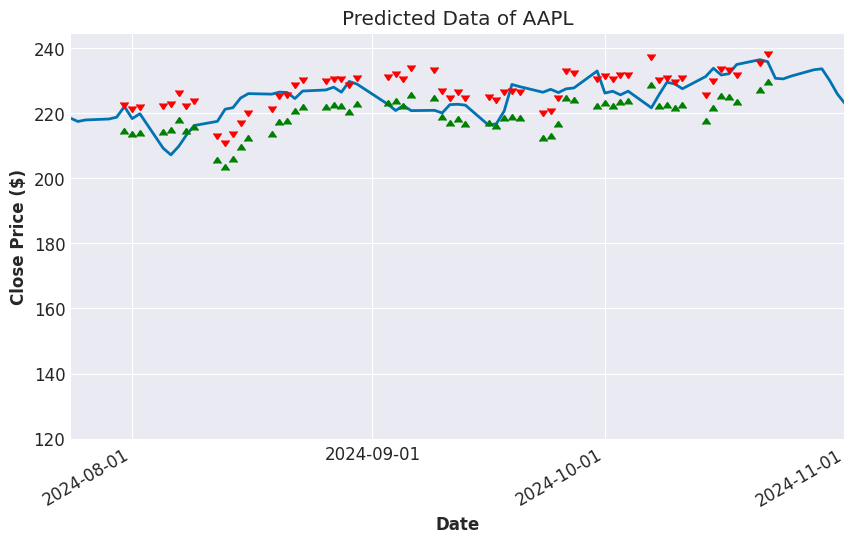

In [ ]:
import matplotlib.markers as markers

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size for clarity

# Format the x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate date labels

# Plot the indexes
index = pd.to_datetime(_df['_Date'])
sns.lineplot(_df, x=index, y='Close', ax=ax)

# Set x-axis limits explicitly
ax.set_xlim(index.iloc[X_test.index.min():].min(), index.max())

outcomes = {o: list(map(float, o.split("_")[1][1:-1].split(","))) for o in y_cols}

def extract_min_max_target(target):
    return outcomes[y_cols[target.argmax()]]

# Plot the data
i = X_test.index.min() + PREDICTION_WINDOW
for real, prediction in zip(y_test, y_pred):
    pmin, pmax = extract_min_max_target(prediction)
    rmin, rmax = extract_min_max_target(real)

    plt.plot(index.iloc[i], _df.loc[i-PREDICTION_WINDOW, "Close"] * (1+pmin), marker=markers.CARETUPBASE, color="green")
    plt.plot(index.iloc[i], _df.loc[i-PREDICTION_WINDOW, "Close"] * (1+pmax), marker=markers.CARETDOWNBASE, color="red")
    i += 1

plt.title(f"Predicted Data of {TICKER}")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.show()

### LSTM Continuous

This section will attempt to use LSTM to make rolling predictions in order to generate predictions over a specified period of time.

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Preprocessing
data = df['Close'].values
data = data.reshape(-1, 1)  # Reshape for scaling

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])  # previous 60 days
        y.append(data[i, 0])  # current day's close
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(data_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X)-10)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Rolling prediction
predictions = []
inputs = X_test[0]

for i in range(len(X_test)):
    predicted_stock_price = model.predict(inputs.reshape(1, time_step, 1))
    predictions.append(predicted_stock_price[0][0])
    inputs = np.append(inputs[1:], predicted_stock_price, axis=0)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actual_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate performance
rmse = mean_squared_error(actual_stock_price, predictions) ** .5
print(f"RMSE: {rmse}")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [ ]:
# Make predictions on training data
train_preds = model.predict(X_train)

# Convert y_train and y_test to Pandas Series
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

# Concatenate y_train and y_test
y_combined = pd.concat([y_train, y_test])

# Concatenate y_train and y_test
pred_combined = np.concatenate((train_preds, predictions))

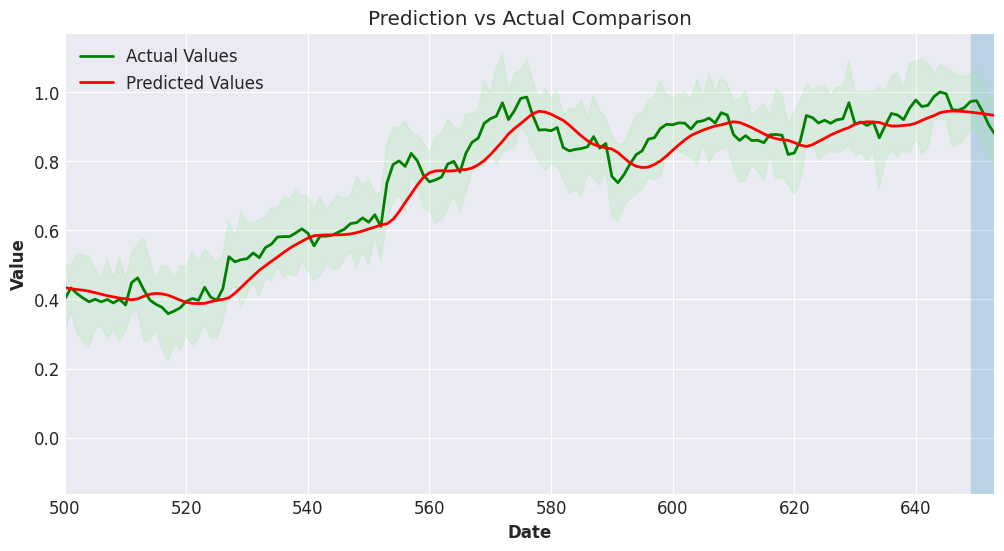

In [ ]:
# Convert y_combined to a NumPy array if it's not already
y_combined_values = y_combined.values
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(y_combined_values, color='green', label='Actual Values')
plt.plot(pred_combined, color='red', label='Predicted Values')
plt.title('Prediction vs Actual Comparison')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Use the correct 'ax'
ax.axvspan(len(y_combined_values)-5, len(y_combined_values), alpha=0.2)

error = np.random.normal(0.1, 0.02, size=y.shape)
plt.fill_between(pd.DataFrame(pred_combined).index, y-error, y+error, alpha=0.2, color='lightgreen')

ax.set_xlim(500, len(y_combined_values)-1)

plt.show()

#**7. Results:**

**What we've observed:**

Throughout this assignment, we have seen how hard it is to predict the stock market:
- rightfully so, though, if it was that easy, everyone would do it.

We achieved an accuracy of approximately 55% for one model, which is a notable result in the context of financial markets. Considering that most stock market indexes historically average around a 10% annual return, being able to predict stock movements with better-than-random accuracy (above 50%) demonstrates the model's potential value in this domain.

Though we did not use many evaluation metrics, this was purposeful, as different predictions have greatly different weights to them (e.g. a prediction that is consistently 10% off is much better than a prediction that is 80% off once or twice)

The most important model in this project (in our opinion) is the HMM. It is extremely difficult to predict the stock market, as there are different conditions that have mean different features may have vastly differnt outcomes.

The HMM has the potential to help us identify these regions, however, does need some human input, or a wrapper to help manage logic.